In [1]:
# import zipfile
# #解压缩文件到路径
# f = zipfile.ZipFile("traindata.zip",'r') # 压缩文件位置
# for file in f.namelist():
#     print(file)
#     f.extract(file,"")               # 解压位置
# f.close()
# f = zipfile.ZipFile("testdata.zip",'r') # 压缩文件位置
# for file in f.namelist():
#     print(file)
#     f.extract(file,"test/")               # 解压位置
# f.close()
# '''
# 文件目录
# ---train
#     ---imgae
#     ---mask
# ---test
#     ---image
# ---infers
# --models
# ---base.ipynb
# '''

In [2]:
#加载一些基础的库
import torch
import os
import numpy as np
import torchvision
from tqdm import tqdm #一个实现进度条的库
import random

In [3]:
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import cv2

transform=transforms.Compose({
    #转化为Tensor
    transforms.ToTensor()
})

#首先继承Dataset写一个对于数据进行读入和处理的方式
class MyDataset(Dataset):
    def __init__(self,path):
        self.mode=('train' if 'mask' in os.listdir(path) else 'test')#表示训练模式
        self.path=path#图片路径
        dirlist=os.listdir(path+'image/')#图片的名称
        self.name=[n for n in dirlist if n[-3:]=='png'] #只读取图片
        
    def __len__(self):
        return len(self.name)
    
    def __getitem__(self,index):#获取数据的处理方式
        name=self.name[index]
        #读取原始图片和标签
        if self.mode=='train':#训练模式
            ori_img=cv2.imread(self.path+'image/'+name)#原始图片
            lb_img=cv2.imread(self.path+'mask/'+name)#标签图片
            ori_img=cv2.cvtColor(ori_img,cv2.COLOR_BGR2RGB)#转为RGB三通道图
            lb_img=cv2.cvtColor(lb_img,cv2.COLOR_BGR2GRAY)#掩膜转为灰度图
            return transform(ori_img),transform(lb_img)
        
        if self.mode=='test':#测试模式
            ori_img=cv2.imread(self.path+'image/'+name)#原始图片
            ori_img=cv2.cvtColor(ori_img,cv2.COLOR_BGR2RGB)#转为RGB三通道图
            return transform(ori_img)

#加载数据集
train_path='train/'
traindata=MyDataset(train_path)

原始图片张量的形状: torch.Size([3, 352, 704])
标签图片张量的形状: torch.Size([1, 352, 704])


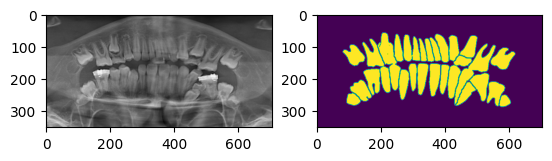

In [4]:
#查看图片读取效果
import matplotlib.pyplot as plt
o_img,l_img=traindata[np.random.randint(0,2000)]
plt.subplot(1,2,1)
plt.imshow(o_img.permute(1,2, 0))
plt.subplot(1,2,2)
plt.imshow(l_img.permute(1,2, 0))
print("原始图片张量的形状:",o_img.shape)
print("标签图片张量的形状:",l_img.shape)#([1, 320, 640]) 其中 1 表示分类类别，我们为2分类任务,类别表示为01

In [5]:
#配置模型超参数
#模型保存的路径
model_path='models/'
#推荐使用gpu进行训练
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
#学习率
lr=3e-3
#学习率衰减
weight_decay=1e-3
#批大小
bs=8
#训练轮次
epochs=10

In [6]:
import torchvision
import torch.nn as nn
import segmentation_models_pytorch as smp
'''
加载经典用于医学图像分割的UNet,encoder_name为模型的backbone
encoder_weigths可选imagenet或者None代表是否加载预训练参数
in_channel为输入图像的通道数
classes为分类数目
'''
model = smp.Unet(
        encoder_name="resnet50",  
        encoder_weights='imagenet',
        in_channels=3,
        classes=1,
    )
##打印模型信息
#print(model) 

In [7]:
#训练前准备
from torch.utils.data import DataLoader
#加载模型到gpu或cpu
model.to(device)
#使用Binary CrossEntropy作为损失函数，主要处理二分类问题
# BCEloss=nn.BCELoss()
#加载优化器,使用Adam,主要是炼的快(๑ت๑)
optim=torch.optim.Adam(model.parameters(),lr=lr, weight_decay=weight_decay)
#使用traindata创建dataloader对象
trainloader=DataLoader(traindata,batch_size=bs, shuffle=True, num_workers=1)
#根据赛题评测选用dice_loss，这个是开源代码
def dice_loss(logits, target):
    smooth = 1.
    prob  = torch.sigmoid(logits)
    batch = prob.size(0)
    prob   = prob.view(batch,1,-1)
    target = target.view(batch,1,-1)
    intersection = torch.sum(prob*target, dim=2)
    denominator  = torch.sum(prob, dim=2) + torch.sum(target, dim=2)
    dice = (2*intersection + smooth) / (denominator + smooth)
    dice = torch.mean(dice)
    dice_loss = 1. - dice
    return dice_loss

In [8]:
# #开始炼丹 没有做验证集，各位可以以自己需要去添加
# loss_last=99999
# best_model_name='x'
# #记录loss变化
# for epoch in range(1,epochs+1):
#     for step,(inputs,labels) in tqdm(enumerate(trainloader),desc=f"Epoch {epoch}/{epochs}",
#                                        ascii=True, total=len(trainloader)):
#         #原始图片和标签
#         inputs, labels = inputs.to(device), labels.to(device)
#         out = model(inputs)
#         loss = dice_loss(out, labels)
#         # 后向
#         optim.zero_grad()
#         #梯度反向传播
#         loss.backward()
#         optim.step()
#     #损失小于上一轮则添加
#     if loss<loss_last:
#         loss_last=loss
#         torch.save(model.state_dict(),model_path+'model_epoch{}_loss{}.pth'.format(epoch,loss))
#         best_model_name=model_path+'model_epoch{}_loss{}.pth'.format(epoch,loss)
#     print(f"\nEpoch: {epoch}/{epochs},DiceLoss:{loss}")

tensor([[[[0.5536, 0.5194, 0.5284,  ..., 0.5200, 0.5427, 0.5860],
          [0.4940, 0.4433, 0.4613,  ..., 0.4567, 0.4873, 0.5558],
          [0.4858, 0.4346, 0.4601,  ..., 0.4686, 0.4908, 0.5626],
          ...,
          [0.4848, 0.4315, 0.4585,  ..., 0.4684, 0.4672, 0.4981],
          [0.4960, 0.4431, 0.4649,  ..., 0.4704, 0.4727, 0.5038],
          [0.5560, 0.5199, 0.5318,  ..., 0.5319, 0.5355, 0.5578]]]],
       device='cuda:0')


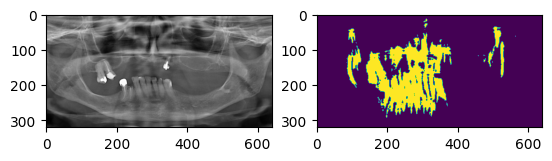

In [96]:
#加载最优模型
model.load_state_dict(torch.load(r'models\model_epoch21_loss0.11355656385421753.pth'))
#加载测试集
test_path='test/'
testdata=MyDataset(test_path)
#测试模型的预测效果
x=np.random.randint(0,500)
inputs=testdata[x].to(device)
with torch.no_grad():
    # 模型预测
    t = model(inputs.view(1,3,320,640))
plt.subplot(1,2,1)
plt.imshow(testdata[x].permute(1,2,0))

t = (t-float(torch.min(t)))/(float(torch.max(t))-float(torch.min(t)))
print(t)
# tensor = torch.ones(1, 1, 320, 640).to(device)
# t = t + tensor
#对预测的图片采取一定的阈值进行分类

threshold=0.8
t= torch.where(t >=threshold, torch.tensor(255,dtype=torch.float).to(device), t)
t= torch.where(t < threshold, torch.tensor(0,dtype=torch.float).to(device), t)

t=t.cpu().view(1,320,640)
plt.subplot(1,2,2)
plt.imshow(t.permute(1,2,0))

In [10]:
from torchvision.utils import save_image
from PIL import Image

img_save_path='infers/'
for i,inputs in tqdm(enumerate(testdata)):
    #原始图片和标签
    inputs=inputs.reshape(1,3,320,640).to(device)
    # 输出生成的图像
    out = model(inputs.view(1,3,320,640)) # 模型预测
    #对输出的图像进行后处理
    threshold=0.5
    out= torch.where(out >=threshold, torch.tensor(255,dtype=torch.float).to(device),out)
    out= torch.where(out < threshold, torch.tensor(0,dtype=torch.float).to(device),out)
    #保存图像
    out= out.detach().cpu().numpy().reshape(1,320,640)
    #注意保存为1位图提交
    img = Image.fromarray(out[0].astype(np.uint8))
    img = img.convert('1')
    img.save(img_save_path + testdata.name[i])

168it [00:08, 20.61it/s]


KeyboardInterrupt: 

In [ ]:
#对保存的图像进行打包
import zipfile

def zip_files(file_paths, output_path):
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for file in file_paths:
            zipf.write(file)
            
#打包图片
file_paths = [img_save_path+i for i in os.listdir(img_save_path) if i[-3:]=='png']
output_path = 'infer.zip'
zip_files(file_paths, output_path)

In [ ]:
'''
线上提交分数
score:0.9032
dice:0.8577
iou:0.9390
hausdorff_distance:0.0719
'''